In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
from numpy.core.fromnumeric import size
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.modules import module
from tqdm import tqdm
import yaml
from torch import optim
import torchvision
from natsort import natsorted
from utils.auxillary import read_config, get_files, tensor2np
from utils.load_data import StackedDataset, Dataloading
from utils.metrics import Results, get_all_metrics

c:\Users\domin\Anaconda3\envs\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read configs

In [2]:
cfg = read_config('configs/config.yml')


# Get file, image and mask list

In [3]:
fileList = get_files(cfg['DATA_PATH'])
# fileList = natsorted(fileList, key=lambda x: int(os.path.splitext(x)[0]))
imageList = get_files(os.path.join(cfg['DATA_PATH'], cfg['IMAGE_PATH']))
imageList = sorted(imageList, key=lambda x: int(os.path.splitext(x)[0]))
maskList = get_files(os.path.join(cfg['DATA_PATH'], cfg['MASK_PATH']))
maskList = sorted(maskList, key=lambda x: int(os.path.splitext(x)[0]))
gtList = get_files(os.path.join(cfg['DATA_PATH'], cfg['GT_PATH']))
gtList = sorted(gtList, key=lambda x: int(os.path.splitext(x)[0]))

In [4]:
# listofmask= []
# for value in maskList:
#     listofmask.append(os.path.join(cfg['DATA_PATH'],cfg['MASK_PATH'],value))
# listofgt= []
# for value in gtList:
#     listofgt.append(os.path.join(cfg['DATA_PATH'],cfg['GT_PATH'],value))
# listofimages = []
# for value in imageList:
#     listofimages.append(os.path.join(cfg['DATA_PATH'],cfg['IMAGE_PATH'],value))

In [5]:
# image_tensor = get_dataloader.get_tensors_list(listofimages)
# mask_tensor = get_dataloader.get_tensors_list_gray(listofmask) 
# gt_tensor = get_dataloader.get_tensors_list_gray(listofgt) 
# stackedlist = []
# for i in range(len(listofmask)): 
#     test = torch.vstack((image_tensor[i], mask_tensor[i]))
#     stackedlist.append(test)

In [6]:
# stack_both = torch.stack(stackedlist)
# stack_both.shape

In [7]:
# stacked_img = torch.stack(image_tensor)
# stacked_img.shape

In [8]:
# stacked_mask = torch.stack(mask_tensor)
# stacked_mask.shape

In [9]:
# stacked_gt = torch.stack(gt_tensor)
# stacked_gt.shape

In [10]:
# from matplotlib import pyplot as plt
# import random
# image_number = random.randint(0, len(stacked_img)-1)
# plt.figure(figsize=(12, 6))
# plt.subplot(121)
# plt.imshow(stack_both[image_number,0,:,:], cmap='gray')
# plt.subplot(122)
# plt.imshow(stacked_img[image_number,0,:,:], cmap='gray')
# plt.show()

In [11]:
# class STLDataset(Dataset):
#     def __init__(self,root_dir = cfg['DATA_PATH'],transform=None):
#         """
#         Args:
#             root_path (string): Directory with all the images.
#             transformer (function): whether to apply the data augmentation scheme
#                 mentioned in the paper. Only applied on the train split.
#         """
#         #load dataset from root dir
#         self.root_dir = root_dir    
#         if transform is None:
#             self.transfrom = transforms.Compose([ transforms.Grayscale(), 
#                                                   transforms.ToTensor(),])
#             self.transfrom2 = transforms.Compose([transforms.ToTensor(),])
#     def __len__(self):
#         return len(fileList)
#     def __getitem__(self,index):
#         filename = fileList[index]
#         image = Image.open(self.root_dir+cfg['IMAGE_PATH']+filename).convert('RGB')
#         mask = Image.open(self.root_dir+cfg['MASK_PATH']+filename)
#         gt = Image.open(self.root_dir+ cfg['GT_PATH']+filename)
#         image = self.transfrom2(image)
#         mask  = self.transfrom(mask)
#         gt  = self.transfrom(gt)
#         stack = torch.vstack((image, mask))
#         return stack,gt

In [12]:
dataset = StackedDataset(cfg, fileList = fileList, root_dir = cfg['DATA_PATH'])

In [13]:
train_dataset,valid_dataset = Dataloading.get_dataset(dataset=dataset,random_seed = cfg['RANDOM_SEED'],valid_ratio=0.12)

In [14]:
# train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False)
# valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
# test_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

In [15]:
# # Display image and label.
# train_features, train_labels = next(iter(test_dataloader))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")
# # img = train_features[0].squeeze()
# label = train_labels[0].squeeze()
# plt.imshow(label, cmap="gray")
# plt.show()

In [16]:
from configs.channelconfig import get_cfg_defaults
modelcfg = get_cfg_defaults()
# cfg.merge_from_file("config.yml")
modelcfg.freeze()
print(modelcfg)

ALIGN_CORNERS: None
BN_MOMENTUM: 1
CHANNELS: 4
FINAL_CONV_KERNEL: 1
PRETRAINED: working\saved_model.pth
STAGE1:
  BLOCK: BOTTLENECK
  FUSE_METHOD: SUM
  NUM_BLOCKS: [2]
  NUM_BRANCHES: 1
  NUM_CHANNELS: [64]
  NUM_MODULES: 1
STAGE2:
  BLOCK: BASIC
  FUSE_METHOD: SUM
  NUM_BLOCKS: [2, 2]
  NUM_BRANCHES: 2
  NUM_CHANNELS: [18, 36]
  NUM_MODULES: 1
STAGE3:
  BLOCK: BASIC
  FUSE_METHOD: SUM
  NUM_BLOCKS: [2, 2, 2]
  NUM_BRANCHES: 3
  NUM_CHANNELS: [18, 36, 72]
  NUM_MODULES: 3
STAGE4:
  BLOCK: BASIC
  FUSE_METHOD: SUM
  NUM_BLOCKS: [2, 2, 2, 2]
  NUM_BRANCHES: 4
  NUM_CHANNELS: [18, 36, 72, 144]
  NUM_MODULES: 2


In [17]:
from train import train_hrnet, test_hrnet,model_pipeline, make_model

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
model, best_iou = model_pipeline(modelcfg, lr= cfg['LEARNING_RATE'], epochs=cfg['EPOCHS'], device = device, train_dataset = train_dataset, valid_dataset = valid_dataset, SAVE_PATH = cfg['SAVE_PATH'], RUN_NAME = cfg['RUN_NAME'],prev_model = None)

HighResolutionNet(
  (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inpla

100%|██████████| 30/30 [06:35<00:00, 13.19s/it]
C:\Users\domin\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\domin\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 0 | Train loss: 0.689 | Train IoU: 0.686 | Time: 395.6s
Train Acc: 0.942 | Train Precision:0.823| Train Recall :0.809 | Train F1 Score:0.807.
 Train DSC :0.807 | Train FM:0.314.


 33%|███▎      | 1/3 [00:04<00:08,  4.37s/it]

torch.Size([1, 1, 500, 300])


 67%|██████▋   | 2/3 [00:08<00:04,  4.24s/it]

torch.Size([1, 1, 500, 300])


100%|██████████| 3/3 [00:12<00:00,  4.28s/it]

torch.Size([1, 1, 500, 300])
Epoch: 0 | Valid loss: 0.693 | Valid IoU: 0.000 | Time: 395.6s



100%|██████████| 30/30 [06:27<00:00, 12.91s/it]


Epoch: 1 | Train loss: 0.647 | Train IoU: 0.897 | Time: 387.4s
Train Acc: 0.985 | Train Precision:0.965| Train Recall :0.928 | Train F1 Score:0.945.
 Train DSC :0.945 | Train FM:0.103.


 33%|███▎      | 1/3 [00:04<00:08,  4.38s/it]

torch.Size([1, 1, 500, 300])


 67%|██████▋   | 2/3 [00:08<00:04,  4.23s/it]

torch.Size([1, 1, 500, 300])


100%|██████████| 3/3 [00:13<00:00,  4.36s/it]

torch.Size([1, 1, 500, 300])
Epoch: 1 | Valid loss: 0.665 | Valid IoU: 0.528 | Time: 387.4s



100%|██████████| 30/30 [06:44<00:00, 13.47s/it]


Epoch: 2 | Train loss: 0.644 | Train IoU: 0.932 | Time: 404.0s
Train Acc: 0.990 | Train Precision:0.980| Train Recall :0.951 | Train F1 Score:0.965.
 Train DSC :0.965 | Train FM:0.068.


 33%|███▎      | 1/3 [00:04<00:08,  4.50s/it]

torch.Size([1, 1, 500, 300])


 67%|██████▋   | 2/3 [00:09<00:04,  4.51s/it]

torch.Size([1, 1, 500, 300])


100%|██████████| 3/3 [00:14<00:00,  4.94s/it]

torch.Size([1, 1, 500, 300])
Epoch: 2 | Valid loss: 0.643 | Valid IoU: 0.944 | Time: 404.0s


In [20]:
from inference import infer

In [21]:
criterion = nn.BCEWithLogitsLoss()

In [22]:
test_loss, mean_iou, predictions,image_list, mask_list, pred, img, mak= infer(model, cfg, device, valid_dataset, criterion, best_iou, cfg['EPOCHS'])

100%|██████████| 3/3 [00:13<00:00,  4.44s/it]

Epoch: 3 | Test loss: 0.643 | Train IoU: 0.944)


In [23]:
# import PIL.Image as Image

In [24]:
# %matplotlib inline
# import imageio
# imageio.imwrite('filename.jpeg', predictions[2])
# im = Image.fromarray(predictions[2])
# import matplotlib.pyplot as plt
# plt.imshow(im)

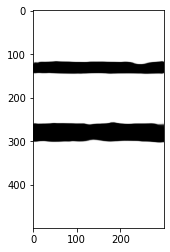

In [25]:
import matplotlib.pyplot as plt
from torchvision import transforms
# image = transforms.ToPILImage()(mak)
plt.imshow(predictions[2],cmap='Greys')
plt.imsave(str(os.path.join(cfg['SAVE_PATH'] + 'HRNET_predicted.jpeg')), mask_list[2], cmap='Greys')

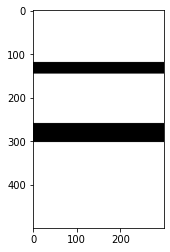

In [26]:
plt.imshow(mask_list[2],cmap='Greys')
plt.imsave(str(os.path.join(cfg['SAVE_PATH'] + 'mask.jpeg')), mask_list[2], cmap='Greys')